In [5]:
%matplotlib inline
import time 
from qutip import mesolve, steadystate
import numpy as np
import matplotlib.pyplot as plt
#from importlib import reload

# custom scripts 
import optical as EM
import phonons as RC
import leads as FL
from utils import *
from photocell_setup import *
from style import *

In [6]:
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rc('grid', linestyle="--", color='grey')
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.3
plt.rcParams['lines.linewidth'] = 2.3
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']


colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
colors+=colours

In [70]:
def plot_voltage_current_only(data_dict, label=None, plot_CC=False,
                         fig = None, ax= (None, None), IV_lab=None, limit_y=False, y_offset=0):
    # if 
    _PARAMS = data_dict['PARAMS']
    if fig==None:
        fig, ax = plt.subplots(1, 1, figsize=(8,10), sharex=True)
    
    X = data_dict['bias_voltages']
    
    ax.set_xlabel('Bias voltage (eV)')
    ax.set_ylabel(r'Current $(10^{-4} 1/T)$')
    #ax1.plot(X, np.array(data_dict['ground_population']).real, label=r'v')
    #ax1.plot(X, np.array(data_dict['hole_population']).real, label=r'h')
    #ax1.plot(X, np.array(data_dict['electron_population']).real, label=r'e')
    #ax1.plot(X, np.array(data_dict['exciton_population']).real, label=r'exc')
    #plt.subplots_adjust(left=0.18, bottom=0.065, right=0.97, top=0.98, wspace=0.24, hspace=0.015)
    q = 1.602176634e-19 # coulomb
    current = np.array(data_dict['current']).real/(10**(-4)) # in electrons per second?
    ax.plot(X, current, label=IV_lab)
    if limit_y:
        ax.set_ylim(-short_current(X,current)*0.1+y_offset, short_current(X,current)*1.3+y_offset)
        ax.set_xlim(0, estimate_Voc(X,current)*1.1)
    if label:
        plt_title = "PLOTS/I-V-{}.pdf".format(label)
        plt.savefig(plt_title)
        print("saved at "+plt_title)

In [113]:
def plot_voltage_current(data_dict, label=None, plot_CC=False,
                         fig = None, axes= (None, None), IV_lab=None, limit_y=False, y_offset=0):
    # if 
    _PARAMS = data_dict['PARAMS']
    if fig==None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), sharex=True)
    else:
        (ax1, ax2) = axes
        
    X = data_dict['bias_voltages']
    red_mu_R, red_mu_L = _PARAMS['omega_c'], 2*_PARAMS['mu']-_PARAMS['omega_c']
    blue_mu_R  = 2*_PARAMS['mu']+_PARAMS['omega_v']
    blue_mu_L = -_PARAMS['omega_v']
    
    
    if abs(_PARAMS['binding_energy'])>0:
        redish_mu_R = _PARAMS['omega_c']-_PARAMS['binding_energy']
        redish_mu_L = 2*_PARAMS['mu']-(_PARAMS['omega_c']-_PARAMS['binding_energy'])
        redish_mu_R/= ev_to_inv_cm
        redish_mu_L/= ev_to_inv_cm
        ax2.axvline(redish_mu_R - redish_mu_L, linestyle='dashed', color=colors[0], linewidth=2.3)
        
        blueish_mu_R  = 2*_PARAMS['mu']+(_PARAMS['omega_v']-_PARAMS['binding_energy'])
        blueish_mu_L = -(_PARAMS['omega_v']-_PARAMS['binding_energy'])
        blueish_mu_R/= ev_to_inv_cm
        blueish_mu_L/= ev_to_inv_cm
        ax2.axvline(blueish_mu_R - blueish_mu_L, linestyle='dashed', color=colors[1], linewidth=2.3)
        
    
    red_mu_R /= ev_to_inv_cm
    red_mu_L /= ev_to_inv_cm
    blue_mu_R/= ev_to_inv_cm
    blue_mu_L/= ev_to_inv_cm
    
    ax2.axvline(blue_mu_R-blue_mu_L, linestyle='dotted', color=colors[1], linewidth=3)
    ax2.axvline(red_mu_R-red_mu_L, linestyle='dotted', color=colors[0], linewidth=3)
    if plot_CC:
        ax1.plot(X, np.array(data_dict['CC_population']).real, label=r'$n_{CC}$')
    else:
        ax1.plot(X, np.array(data_dict['conduction_population']).real, label=r'$n_c$', 
                 ls="dashdot", linewidth=2.6, alpha=1.)
        ax1.plot(X, np.array(data_dict['valence_population']).real, label=r'$n_v$', alpha=0.8)
        #ax1.plot(X, np.array(data_dict['exciton_population']).real, label=r'$n_x$')
        
    ax1.set_ylabel('Population')
    ax2.set_xlabel('Bias voltage (eV)')
    ax2.set_ylabel(r'Current $(10^{-4} [T^{-1}])$')
    
    plt.subplots_adjust(left=0.18, bottom=0.065, right=0.97, top=0.98, wspace=0.24, hspace=0.015)
    ax1.legend()
    current = np.array(data_dict['current']).real/(10**(-4)) # in electrons per second?
    ax2.plot(X, current, label=IV_lab, color='#606060')
    
    ax1.set_xlim(0, X[-1])
    if limit_y:
        ax2.set_ylim(-short_current(X,current)*0.1+y_offset, short_current(X,current)*1.3+y_offset)
        ax2.set_xlim(0, estimate_Voc(X,current)*1.1)
    ax2.ticklabel_format(style='sci',axis='y')
    if label:
        plt_title = "PLOTS/I-V-pop-{}.pdf".format(label)
        plt.savefig(plt_title)
        print("saved at "+plt_title)

# I-V diagram: $\mu$ is central in bandgap

In [8]:
omega_v = 300e-3
num_voltages = 100

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_no_BE_1 = populations_and_current_vs_voltage(PARAMS, x_range=[0.3,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.02*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=700e-3, bias_voltage=0, N=2, silent=True, T_C=50.)

data_dict_1 = populations_and_current_vs_voltage(PARAMS, x_range=[0.3,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.04*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=700e-3, bias_voltage=0, N=2, silent=True, T_C=50.)

data_dict_2 = populations_and_current_vs_voltage(PARAMS, x_range=[0.3,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.06*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=700e-3, bias_voltage=0, N=2, silent=True, T_C=50.)

data_dict_3 = populations_and_current_vs_voltage(PARAMS, x_range=[1.2,2.3], num_voltages=num_voltages)

C-V data calculated in 73.9 seconds
C-V data calculated in 74.9 seconds
C-V data calculated in 68.9 seconds
C-V data calculated in 71.4 seconds


saved at PLOTS/I-V-mu-central.pdf


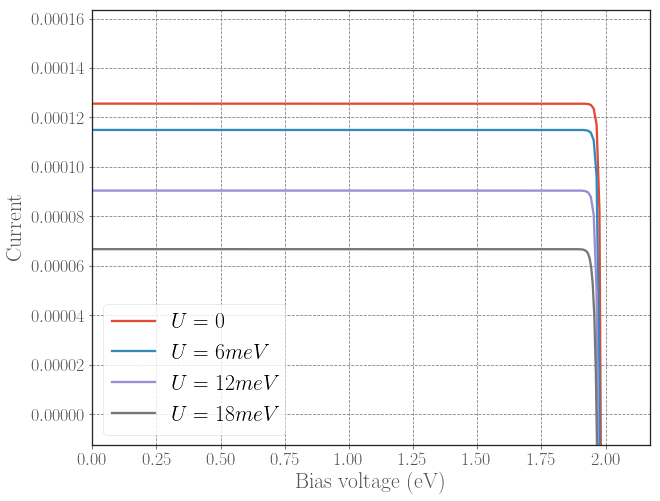

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True)
plot_voltage_current_only(data_dict_no_BE_1, fig=fig, ax=ax, IV_lab=r"$U=0$", limit_y=True)
plot_voltage_current_only(data_dict_1, fig=fig, ax=ax, IV_lab=r"$U=6meV$")
plot_voltage_current_only(data_dict_2, fig=fig, ax=ax, IV_lab=r"$U=12meV$")
plot_voltage_current_only(data_dict_3, fig=fig, ax=ax, IV_lab=r"$U=18meV$", label='mu-central')
ax.legend()

saved at PLOTS/I-V-pop-central.pdf


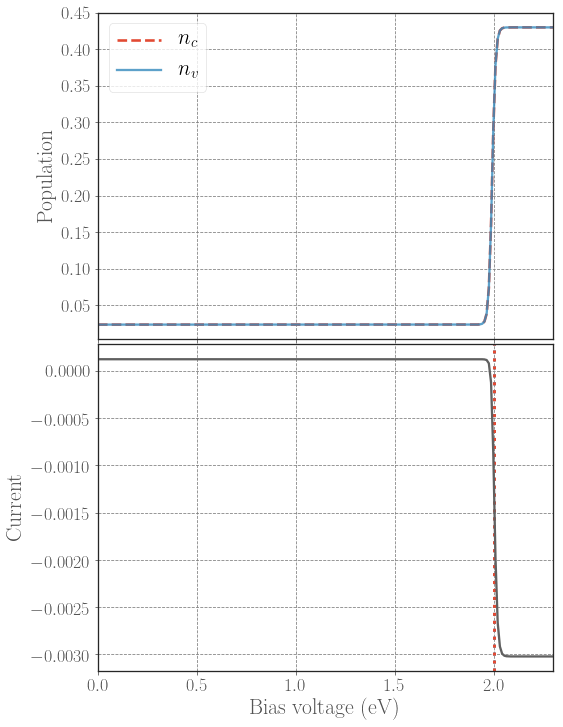

In [13]:
plot_voltage_current(data_dict_no_BE_1, label='central', plot_CC=False,
                         fig = None, axes= (None, None), IV_lab=None, limit_y=False, y_offset=0)

# I-V diagram: $\mu$ is above bandgap

In [14]:
omega_v = 300e-3
mu = 800e-3
num_voltages = 100
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_no_BE_2 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.02*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=mu, bias_voltage=0, N=2, silent=True, T_C=50.)

data_dict_1 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.04*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=mu, bias_voltage=0, N=2, silent=True, T_C=50.)

data_dict_2 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.06*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=mu, bias_voltage=0, N=2, silent=True, T_C=50.)

data_dict_3 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

C-V data calculated in 77.1 seconds
C-V data calculated in 70.9 seconds
C-V data calculated in 68.4 seconds
C-V data calculated in 68.9 seconds


saved at PLOTS/I-V-mu-above.pdf


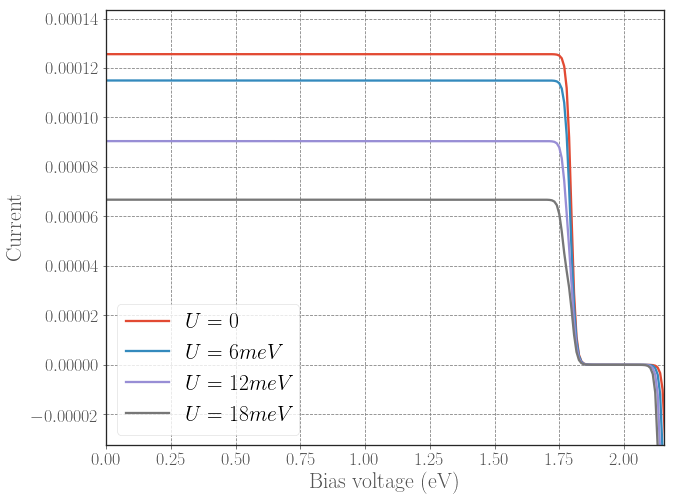

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True)
plot_voltage_current_only(data_dict_no_BE_2, fig=fig, ax=ax, IV_lab=r"$U=0$", limit_y=True, y_offset=-2e-5)
plot_voltage_current_only(data_dict_1, fig=fig, ax=ax, IV_lab=r"$U=6meV$")
plot_voltage_current_only(data_dict_2, fig=fig, ax=ax, IV_lab=r"$U=12meV$")
plot_voltage_current_only(data_dict_3, fig=fig, ax=ax, IV_lab=r"$U=18meV$", label='mu-above')
ax.legend()

saved at PLOTS/I-V-pop-above.pdf


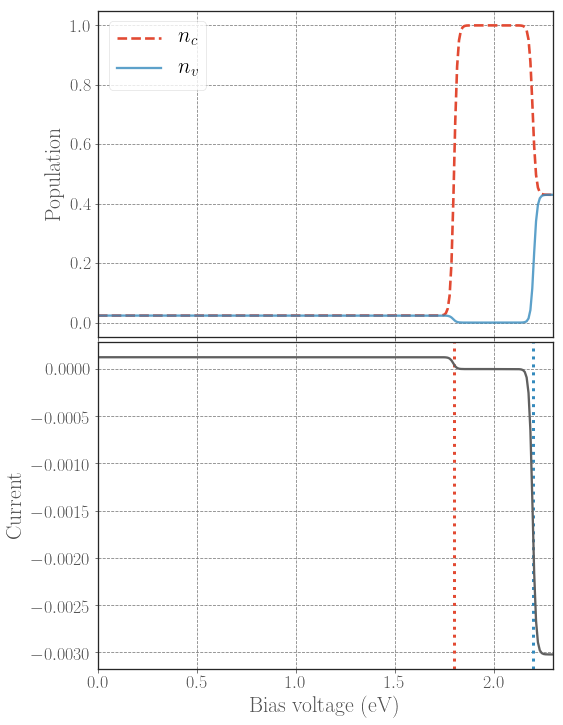

In [17]:
plot_voltage_current(data_dict_no_BE_2, label='above', plot_CC=False,
                         fig = None, axes= (None, None), IV_lab=None, limit_y=False, y_offset=0)

In [18]:
def plot_power_current_only(data_dict, label=None, plot_CC=False,
                         fig = None, ax= (None, None), IV_lab=None, limit_y=False, y_offset=0):
    # if 
    _PARAMS = data_dict['PARAMS']
    if fig==None:
        fig, ax = plt.subplots(1, 1, figsize=(8,10), sharex=True)
    
    X = data_dict['bias_voltages']
    
    ax.set_xlabel('Bias voltage (eV)')
    ax.set_ylabel('Power')
    
    q = 1.602176634e-19 # coulomb
    current = np.array(data_dict['current']).real # in electrons per second?
    power = power_values(X, current)
    ax.plot(X, power, label=IV_lab)
    if limit_y:
        ax.set_ylim(0-y_offset, max(power)*1.+y_offset)
        ax.set_xlim(0, estimate_Voc(X,current)*1.1)
    if label:
        plt_title = "PLOTS/P-V-{}.pdf".format(label)
        plt.savefig(plt_title)
        print("saved at "+plt_title)

saved at PLOTS/P-V-mu-above.pdf


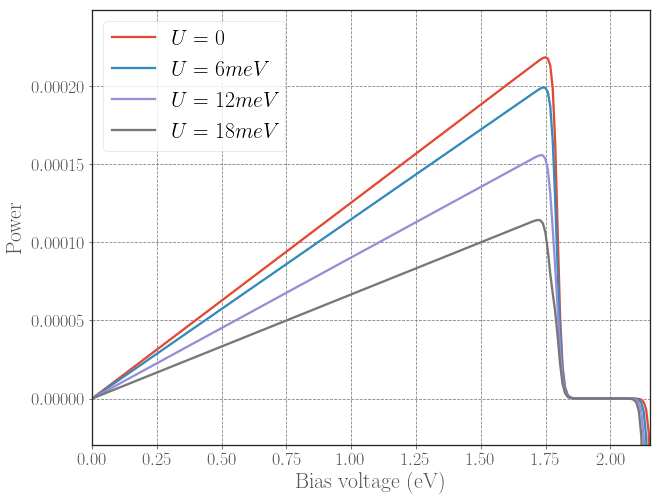

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True)
plot_power_current_only(data_dict_no_BE_2, fig=fig, ax=ax, IV_lab=r"$U=0$", limit_y=True, y_offset=3e-5)
plot_power_current_only(data_dict_1, fig=fig, ax=ax, IV_lab=r"$U=6meV$")
plot_power_current_only(data_dict_2, fig=fig, ax=ax, IV_lab=r"$U=12meV$")
plot_power_current_only(data_dict_3, fig=fig, ax=ax, IV_lab=r"$U=18meV$", label='mu-above')
ax.legend()

In [20]:
omega_v = 300e-3
mu = 800e-3
num_voltages = 100
T_C = 300
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=T_C)
data_dict_no_BE = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.02*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=mu, bias_voltage=0, N=2, silent=True, T_C=T_C)

data_dict_1 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.04*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=mu, bias_voltage=0, N=2, silent=True, T_C=T_C)

data_dict_2 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0.06*omega_v, radiative_lifetime=1, 
                      alpha_ph=0, mu=mu, bias_voltage=0, N=2, silent=True, T_C=T_C)

data_dict_3 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)


C-V data calculated in 41.4 seconds
C-V data calculated in 41.9 seconds
C-V data calculated in 39.5 seconds
C-V data calculated in 38.2 seconds


saved at PLOTS/I-V-mu-below.pdf


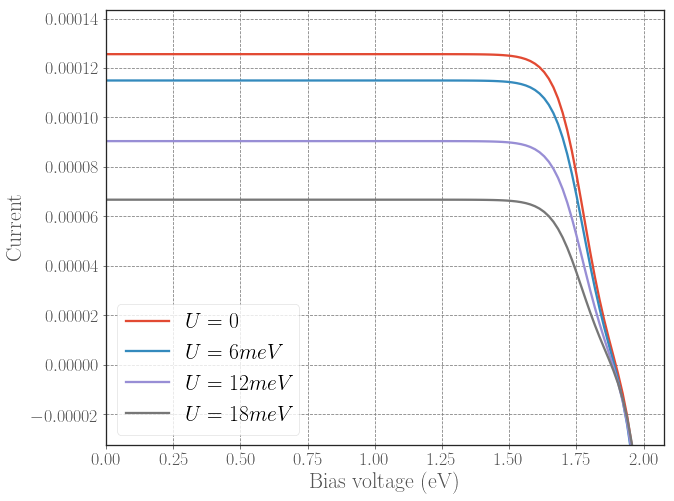

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True)
plot_voltage_current_only(data_dict_no_BE, fig=fig, ax=ax, IV_lab=r"$U=0$", limit_y=True, y_offset=-2e-5)
plot_voltage_current_only(data_dict_1, fig=fig, ax=ax, IV_lab=r"$U=6meV$")
plot_voltage_current_only(data_dict_2, fig=fig, ax=ax, IV_lab=r"$U=12meV$")
plot_voltage_current_only(data_dict_3, fig=fig, ax=ax, IV_lab=r"$U=18meV$", label='mu-below')
ax.legend()

In [26]:
# We don't need different binding energies for 'below' as we don't show this

omega_v = 300e-3
mu = 600e-3
num_voltages = 100
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_no_BE_3 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)



C-V data calculated in 70.7 seconds


# Plotting Triptychs: no binding energy

In [75]:
def plot_triptych(dd1, dd2, dd3, label=None):
    fig, axs = plt.subplots(2, 3, figsize=(14,8), sharex=True)
    for i, dd in zip(range(3), [dd1, dd2, dd3]):
        plot_voltage_current(dd, label=None, plot_CC=False,
                         fig = fig, axes= (axs[0,i], axs[1,i]), limit_y=False, y_offset=0)
    plt.subplots_adjust(left=0.1, bottom=0.09, right=0.97, top=0.98, wspace=0.016, hspace=0.016)
    
    for ax in axs.flat:
        ax.label_outer()
        
    if label:
        plot_name = "PLOTS/T"+label+".pdf"
        plt.savefig(plot_name)
        print("saved at "+plot_name)


saved at PLOTS/T1-no-BE.pdf


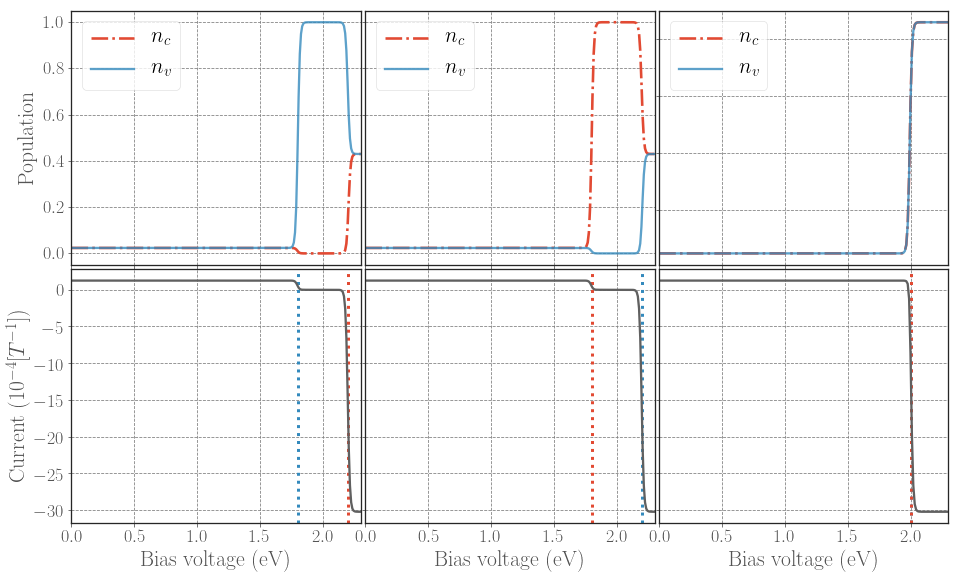

In [112]:
plot_triptych(data_dict_no_BE_3, 
              data_dict_no_BE_2, 
              data_dict_no_BE_1, label="1-no-BE")

# Triptych with binding energy

In [78]:
omega_v = 300e-3
mu = 800e-3
num_voltages = 100
U = 300e-3
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=U, radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_BE_1 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)


mu = 700e-3
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=U, radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_BE_2 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

mu = 600e-3
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=U, radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_BE_3 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)



C-V data calculated in 75.4 seconds
C-V data calculated in 74.1 seconds
C-V data calculated in 73.0 seconds


saved at PLOTS/T2-BE.pdf


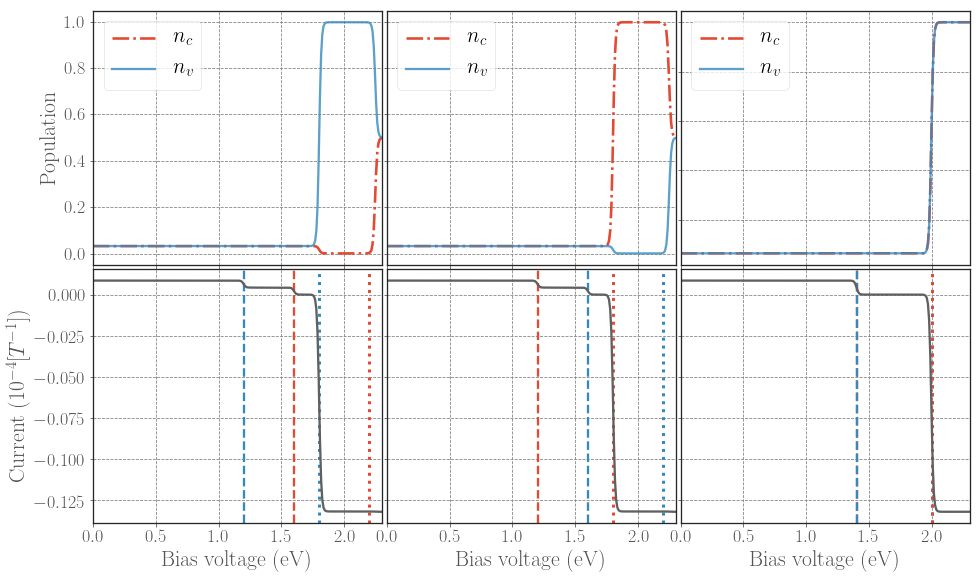

In [114]:
plot_triptych(data_dict_BE_3, 
              data_dict_BE_1, 
              data_dict_BE_2, label="2-BE")

In [81]:
omega_v = 300e-3
mu = 800e-3
num_voltages = 100
U = 150e-3
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=U, radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_BE_1_ = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)


mu = 700e-3
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=U, radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_BE_2_ = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

mu = 600e-3
PARAMS = PARAMS_setup(valence_energy=omega_v, binding_energy=U, radiative_lifetime=1, alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
data_dict_BE_3_ = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)



C-V data calculated in 70.9 seconds
C-V data calculated in 70.3 seconds
C-V data calculated in 71.0 seconds


bare hole: 2.2 	 bare electron: 1.8 	 hole-like: 1.9 	 electron-like: 1.5
bare hole: 2.0 	 bare electron: 2.0 	 hole-like: 1.7 	 electron-like: 1.7
bare hole: 1.8 	 bare electron: 2.2 	 hole-like: 1.5 	 electron-like: 1.9
saved at PLOTS/T2-BE-.pdf


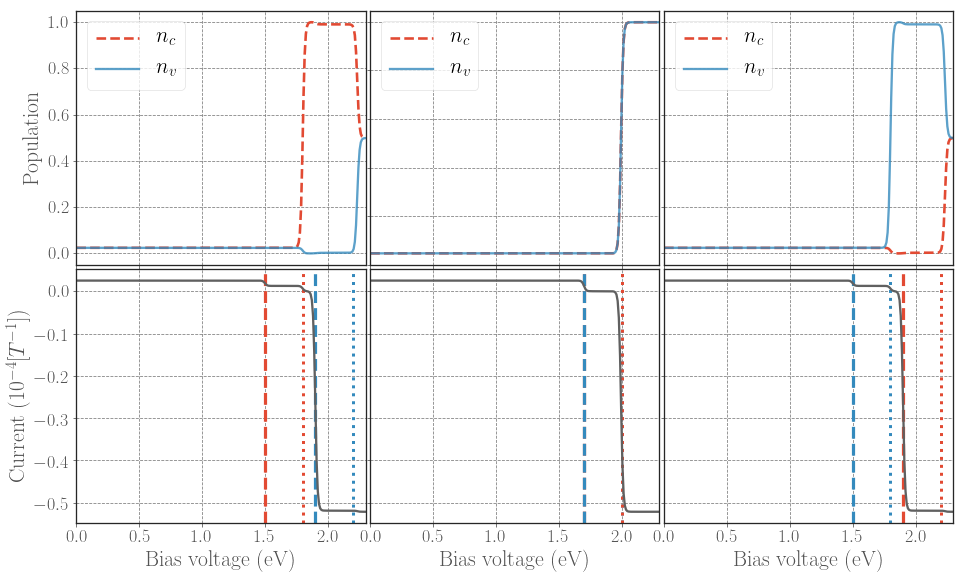

In [102]:
plot_triptych(data_dict_BE_1_, 
              data_dict_BE_2_, 
              data_dict_BE_3_, label="2-BE-")

In [141]:
def P_max_vs_mu(valence_energy=300e-3, alpha_ph=0, N=2, silent=True, T_C=50.,
                num_mu=50, num_voltages=80):
    Pmax_values = []
    mu_values = np.linspace(0.6, 0.8, num_mu)
    U_values = np.array([0, 5e-3, 10e-3, 15e-3])
    for U in U_values:
        P_mu_line = []
        for mu in mu_values:
            PARAMS = PARAMS_setup(valence_energy=valence_energy, binding_energy=U, 
                                  alpha_ph=alpha_ph, mu=mu, N=N, silent=True, T_C=T_C)
            #print_PARAMS(PARAMS)
            dd = populations_and_current_vs_voltage(PARAMS, x_range=[0.8,2.5], 
                                                                   num_voltages=num_voltages)
            P_mu_line.append(max_power(dd['bias_voltages'], dd['current']))
        print("U={} calculated.".format(U))
        Pmax_values.append(P_mu_line)
    return Pmax_values, mu_values, U_values

Pmax_values, mu_values, U_values = P_max_vs_mu(alpha_ph=0, N=2, silent=True, T_C=50.,
                                               num_mu=50, num_voltages=90)

C-V data calculated in 63.8 seconds
C-V data calculated in 61.1 seconds
C-V data calculated in 61.0 seconds
C-V data calculated in 61.2 seconds
C-V data calculated in 61.3 seconds
C-V data calculated in 61.1 seconds
C-V data calculated in 61.3 seconds
C-V data calculated in 61.4 seconds
C-V data calculated in 61.3 seconds
C-V data calculated in 61.2 seconds
C-V data calculated in 61.3 seconds
C-V data calculated in 64.6 seconds
C-V data calculated in 61.2 seconds
C-V data calculated in 61.5 seconds
C-V data calculated in 60.9 seconds
C-V data calculated in 61.1 seconds
C-V data calculated in 61.1 seconds
C-V data calculated in 60.9 seconds
C-V data calculated in 61.0 seconds
C-V data calculated in 61.1 seconds
C-V data calculated in 61.4 seconds
C-V data calculated in 61.5 seconds
C-V data calculated in 61.4 seconds
C-V data calculated in 61.3 seconds
C-V data calculated in 61.4 seconds
C-V data calculated in 61.3 seconds
C-V data calculated in 61.5 seconds
C-V data calculated in 61.6 

In [157]:
def plot_P_max_diagram(Pmax_values, mu_values, U_values):
    fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True)
    for i, U in enumerate(U_values):
        ax.plot(mu_values, Pmax_values[i], label='U={}meV'.format(int(U*1000)))
    plt.xlim(mu_values[0], mu_values[-1])
    plt.legend()
    plt.savefig("PLOTS/P_max_wrt_mu.pdf")

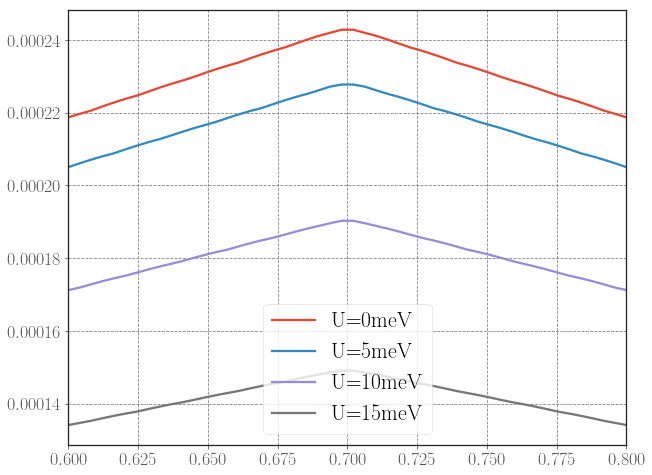

In [158]:
plot_P_max_diagram(Pmax_values, mu_values, U_values)

# Testing: does decreasing the excitonic energy decrease current?

In [136]:
mu = 700e-3
PARAMS = PARAMS_setup(valence_energy=300e-3, bandgap=1.4, binding_energy=0., radiative_lifetime=1, 
                      alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
test_dd_1 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=200e-3, bandgap=1.4, binding_energy=0., radiative_lifetime=1, 
                      alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
test_dd_2 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=100e-3, bandgap=1.4, binding_energy=0., radiative_lifetime=1, 
                      alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
test_dd_3 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

PARAMS = PARAMS_setup(valence_energy=0, bandgap=1.4, binding_energy=0., radiative_lifetime=1, 
                      alpha_ph=0, mu=mu,
                      bias_voltage=0, N=2, silent=True, T_C=50.)
test_dd_4 = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,2.3], num_voltages=num_voltages)

C-V data calculated in 72.7 seconds
C-V data calculated in 71.5 seconds
C-V data calculated in 71.2 seconds
C-V data calculated in 69.5 seconds


saved at PLOTS/I-V-peak-shift.pdf


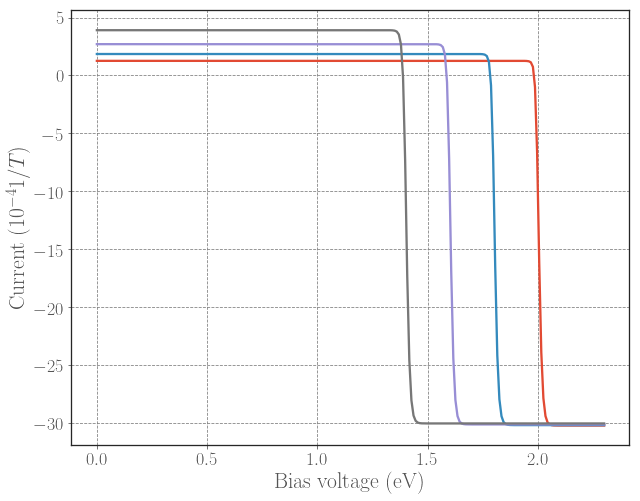

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True)
plot_voltage_current_only(test_dd_1, fig=fig, ax=ax, IV_lab=r"$\epsilon_v=300meV$")
plot_voltage_current_only(test_dd_2, fig=fig, ax=ax, IV_lab=r"$\epsilon_v=200meV$")
plot_voltage_current_only(test_dd_3, fig=fig, ax=ax, IV_lab=r"$\epsilon_v=100meV$")
plot_voltage_current_only(test_dd_4, fig=fig, ax=ax, IV_lab=r"$\epsilon_v=0meV$", label='peak-shift')



saved at PLOTS/P-V-peak-shift.pdf


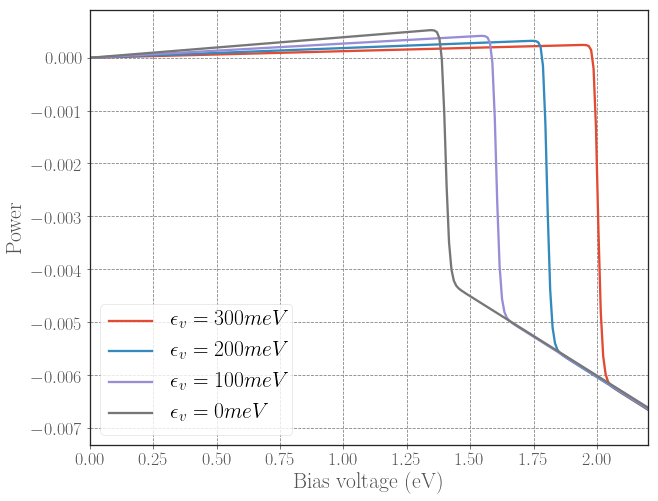

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True)
plot_power_current_only(test_dd_1, fig=fig, ax=ax, IV_lab=r"$\epsilon_v=300meV$")
plot_power_current_only(test_dd_2, fig=fig, ax=ax, IV_lab=r"$\epsilon_v=200meV$")
plot_power_current_only(test_dd_3, fig=fig, ax=ax, IV_lab=r"$\epsilon_v=100meV$")
plot_power_current_only(test_dd_4, fig=fig, ax=ax, IV_lab=r"$\epsilon_v=0meV$", label='peak-shift')
ax.set_xlim(0,2.2)
ax.legend()
